# Warning - The notebook needs the following files to run well:

The database of metabolites used to see the usual ratios between the different elements was from ChEBI, specifically https://www.ebi.ac.uk/chebi/downloadsForward.do. Specifically, two files were used from this site:

- ChEBI_complete_3star.sdf file contains all the chemical structures and associated information of metabolites annotated with a 3 star score in the database (higher reliability) - total of 49266 formulas.
- ChEBI_complete.sdf contains all the chemical structures and associated information of all metabolites in the database - total of 113402 formulas.

#### These files aren't in the repository due to their size, but they can be obtained from the ChEBI database.

The same processes were done for the two different files.

# Formula Generation and Assignment Auxiliary Notebook

# Form_ratio_test - Observation of the most common ratios (in relation to carbon atoms) that metabolites have

In FormGeneration_Assignment, ratios from Kind and Fiehn, 2007 paper were used to make the Database of possible formulas to be assigned. They estimate that these represent 99,7% of metabolites (based on a database analysis). However, the assignment of the formulas sometimes in the extreme of the allowed ratios instead of formulas with more conventional formulas because they have less heteroatoms or are closer to the peak mass. To avoid that, we want to add an extra criteria that prioritizes formulas with more conventional ratios (in metabolites) between their different elements. This criteria was added in form_checker_ratio function that is present at the end of that notebook.

This notebook purpose is to find a good set of stricter ranges use to enforce this extra criteria that we want to add. Thus, it is an auxiliary notebook to FormGeneration_Assignment.ipynb. This was done by analysing a freely available metabolite database (that are presented above - after Warning) and was evaluated by observing cumulative graphs of the % of formulas by their 'H/C', 'O/C', 'N/C', 'S/C', 'P/C', 'F/C' and 'Cl/C' ratios to find a suitable range that still encompasses most formulas but limits the stranger ratios that can be found at the extremes.

### Organization of the notebook:

#### The analysis is performed on two files presented below the Warning in the beginning of the notebook, the analysis on both is identical

- Read and store the metabolites from a database (file 1) and filter them for non-repeated monoisotopic and defined formulas with Carbons and Hydrogens and with only C,H,O,N,S,P,F and Cl elements.
- Calculate the ratios of the formulas of the different elements to carbon ('element'/Carbon) and store.
- Analysis of the most common 'element'/C ratios metabolites have with histogram and cumulative graphs.

- Repeat the process for the second file.

### Needed imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ChEBI with only 3 star annotated metabolites

## Reading and Storing Formulas from a Database 

In [2]:
# Open Database file
with open('ChEBI_complete_3star.sdf/ChEBI_complete_3star.sdf') as file: 
    formula = False
    form=[]
    for line in file:
        # Append all formulas
        if formula == True:
            form.append(line[:-1])
            #print(line[:-1])
        # Read next line
        if line.startswith('> <Formulae>'):
            formula = True
        else:
            formula = False
#form    

In [3]:
# Nº of formulas in the Database
len(form)

49266

### Filter the formulas in the database

Filter formulas with:
- an unspecified R group or X halogen, 
- formulas that could have a section repeated n times (polymers), 
- formulas with non-covalent bonds represented by a '.' such as '(C6H8O6)n.H2O',
- formulas with isotopes such as C6H11[18F]O5,
- formulas without carbons or hydrogens.

In [4]:
formulas = []
tot_form = len(form)

#c,r,n,p,x,n=0,0,0,0,0,0

for i in form:
    if 'C' in i: # Has to have Carbon (this is actually: has to have carbon, Cl, Ca, Cu, Cr, Cs or Cd - fixed later)
        #c=c+1
        if 'R' not in i: # No unspecified R groups
            #r=r+1
            if 'n' not in i: # No polymers with sections that can be repeated n times
                #n=n+1
                if '.' not in i: # No formulas that could have non-covalent bonds
                    #p=p+1
                    if 'X' not in i: # No unspecified X halogens
                        #x=x+1
                        if '[' not in i: # No
                            if 'H' in i: # Has to have Hydrogen (this is actually: has to have hydrogen or mercury - fixed later)
                                #h = h+1
                                formulas.append(i)
#print(c,r,n,p,x,h)
print('Nº of formulas after filtering:', len(formulas))

print('Nº of non-repeating formulas after filtering:', len(set(formulas)))

Nº of formulas after filtering: 43779
Nº of non-repeating formulas after filtering: 21164


There are 43779 formulas remaining after filtering, 21164 of those were unique different formulas (more than half of the formulas were repeated).

In [5]:
#len(set(formulas))
#formulas = set(formulas)
#formulas[:20]

#### Transform formulas into Dictionary/DataFrame format (from string format) and take out repeating formulas (done automatically by this process)

In [6]:
def formula_process(formula):
    """Transforms a formula in string format into a DataFrame. Element order: C, H, N, O, S, P, F, Cl."""
    
    # Make the row DataFrame to store the results
    #results = pd.DataFrame(np.zeros((1,8)), columns = ['C','H','O','N','S','P','Cl','F'])
    results = {}
    count = ''
    letter = None
    
    # Run through the string
    for i in range(len(formula)):
        if formula[i].isupper():
            if letter:
                # Store results of the previous letter
                results[letter] = int(count or 1)
                count = ''
            if i+1 < len(formula):
                # If 2 letter element
                if formula[i+1].islower():
                    letter = formula[i] + formula[i+1]
                    continue
            letter = formula[i]
            
        elif formula[i].isdigit():
            count = count + formula[i]
    
    # Store results of the last letter
    results[letter] = int(count or 1)
                    
    return results

In [7]:
# Transform each formula into Dictionary or DataFrame format
# This also elimiantes repeating formulas
db = {}
for i in formulas:
    #print(i)
    db[i] = formula_process(i)

In [8]:
# Transform information into a DataFrame
final_db = pd.DataFrame.from_dict(db).T
final_db

,C,H,O,Cl,N,P,S,F,Br,I,...,Ti,Zr,Li,Ir,U,Pd,T,Pr,Tl,Ba
C15H14O6,15.0,14.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C10H16O,10.0,16.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C18H22O3,18.0,22.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C7H3Cl2N,7.0,3.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C4H8O3,4.0,8.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C204H301N51O64,204.0,301.0,64.0,NaN,51.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C10H11ClFN5O3,10.0,11.0,3.0,1.0,5.0,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C32H26N4O2,32.0,26.0,2.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C8H10N4O3,8.0,10.0,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


See the elements present in the list of formulas and also the number of times each element appear in a formulas

Note that C appear in 21104 and H in 21159 formulas out of the 21164 formulas, when they should appear in all formulas. This discrepancy is explaiend by the comment made in the formula filtering cell a bit above. It will be solved in a bit.

In [9]:
#final_db[final_db['Se'].notnull()].T
final_db.notnull().sum()

C     21104
H     21159
O     19581
Cl     1746
N     14541
P      4351
S      4462
F       836
Br      368
I       178
K        45
Se       53
Mg       61
Co       67
As       54
Fe       81
Hg       32
Pt       20
Ni       22
W         6
Ca       27
B        66
Si       60
Cu       18
Na      308
V         3
D         8
Bi        4
Sb        4
Au        5
Te        8
Ag        2
Mo       29
Cr       11
Al        6
Pb        5
Os        2
Gd       11
Ge        1
Eu        3
Cs        1
Sr        1
Cd        4
Mu        1
Ti        3
Zr        2
Li       18
Ir        4
U         4
Pd        4
T         1
Pr        1
Tl        1
Ba        1
dtype: int64

#### Guarantee that each formula has at least 1 C and 1 H, and that only have the following elements: C,H,O,N,S,P,Cl and F

Only formulas with C,H,O,N,S,P,Cl and F were kept since they are (as we can also see above) by far the most common elements in metabolites and are the elements that can be considered (right now as it is built) in the Formula Assignment algorithm made in FormGeneration_Assignment.ipynb (this notebook is auxiliary to that one to observe the most common ratios between these elemetns in known metabolites).

In [10]:
# Only keep formulas that have carbon or hydrogen atoms
for i in range(2):
    teste = final_db.iloc[:,i].notnull()
    #print(final_db.iloc[:,i].isnull())
    final_db = final_db.loc[teste]
    
# Take out formulas that have an element outside of the C,H,O,N,S,P,Cl and F
for i in range(8,len(final_db.columns)):
    teste = final_db.iloc[:,i].isnull()
    final_db = final_db.loc[teste]
final_db

,C,H,O,Cl,N,P,S,F,Br,I,...,Ti,Zr,Li,Ir,U,Pd,T,Pr,Tl,Ba
C15H14O6,15.0,14.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C10H16O,10.0,16.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C18H22O3,18.0,22.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C7H3Cl2N,7.0,3.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C4H8O3,4.0,8.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C204H301N51O64,204.0,301.0,64.0,NaN,51.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C10H11ClFN5O3,10.0,11.0,3.0,1.0,5.0,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C32H26N4O2,32.0,26.0,2.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C8H10N4O3,8.0,10.0,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### This finally filters the number of formulas from 21164 to 19593 formulas - final number of formulas considered

As it can be seen by this small filtering, very few formulas had elements outside of the main 8 mentioned.

In [11]:
final_db.notnull().sum()

C     19593
H     19593
O     18255
Cl     1594
N     13495
P      4230
S      4106
F       762
Br        0
I         0
K         0
Se        0
Mg        0
Co        0
As        0
Fe        0
Hg        0
Pt        0
Ni        0
W         0
Ca        0
B         0
Si        0
Cu        0
Na        0
V         0
D         0
Bi        0
Sb        0
Au        0
Te        0
Ag        0
Mo        0
Cr        0
Al        0
Pb        0
Os        0
Gd        0
Ge        0
Eu        0
Cs        0
Sr        0
Cd        0
Mu        0
Ti        0
Zr        0
Li        0
Ir        0
U         0
Pd        0
T         0
Pr        0
Tl        0
Ba        0
dtype: int64

In [12]:
# Truncate the DataFrame to only the elements we want to see and replace NaNs for 0
db_df = final_db[['C','H','O','N','S','P','F','Cl']]
db_df = db_df.replace({np.nan:0})
db_df

,C,H,O,N,S,P,F,Cl
C15H14O6,15.0,14.0,6.0,0.0,0.0,0.0,0.0,0.0
C10H16O,10.0,16.0,1.0,0.0,0.0,0.0,0.0,0.0
C18H22O3,18.0,22.0,3.0,0.0,0.0,0.0,0.0,0.0
C7H3Cl2N,7.0,3.0,0.0,1.0,0.0,0.0,0.0,2.0
C4H8O3,4.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
C204H301N51O64,204.0,301.0,64.0,51.0,0.0,0.0,0.0,0.0
C10H11ClFN5O3,10.0,11.0,3.0,5.0,0.0,0.0,1.0,1.0
C32H26N4O2,32.0,26.0,2.0,4.0,0.0,0.0,0.0,0.0
C8H10N4O3,8.0,10.0,3.0,4.0,0.0,0.0,0.0,0.0


Calculate the distribution of ratios to carbon in the 19593 formulas - slowest cell of this analysis

In [13]:
# Calculate the different ratios 
ratios_df = pd.DataFrame(index=db_df.index, columns = ['H/C','O/C','N/C','S/C','P/C','F/C','Cl/C'])
c = 0
for i in db_df.index:
    ratios_df.loc[i] = [db_df.loc[i,'H']/db_df.loc[i,'C'],
                        db_df.loc[i,'O']/db_df.loc[i,'C'],
                        db_df.loc[i,'N']/db_df.loc[i,'C'],
                        db_df.loc[i,'S']/db_df.loc[i,'C'],
                        db_df.loc[i,'P']/db_df.loc[i,'C'],
                        db_df.loc[i,'F']/db_df.loc[i,'C'],
                        db_df.loc[i,'Cl']/db_df.loc[i,'C']]
    c+=1
    #print(c)
ratios_df

,H/C,O/C,N/C,S/C,P/C,F/C,Cl/C
C15H14O6,0.933333,0.4,0,0,0,0,0
C10H16O,1.6,0.1,0,0,0,0,0
C18H22O3,1.22222,0.166667,0,0,0,0,0
C7H3Cl2N,0.428571,0,0.142857,0,0,0,0.285714
C4H8O3,2,0.75,0,0,0,0,0
...,...,...,...,...,...,...,...
C204H301N51O64,1.47549,0.313725,0.25,0,0,0,0
C10H11ClFN5O3,1.1,0.3,0.5,0,0,0.1,0.1
C32H26N4O2,0.8125,0.0625,0.125,0,0,0,0
C8H10N4O3,1.25,0.375,0.5,0,0,0,0


In [14]:
ratios_df.max()

H/C     12.0
O/C     10.0
N/C      6.0
S/C      3.0
P/C      3.0
F/C      3.0
Cl/C     3.0
dtype: float64

# Analysis of the ratios of 'Element'/Carbon

### Histograms and more importantly Cumulative Graphs of the ratios - Not eliminating ratios with 0

Outside of the ['H/C'] ratios, the ratios were dominated by formulas that didn't have the element that is not carbon which skewed the following results.

#### Histograms of the each of the ratios

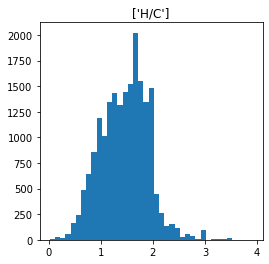

In [15]:
f, ax = plt.subplots(figsize=(4,4))
data = ratios_df['H/C']
plt.hist(data, bins=np.arange(min(data), 4, 0.1))
plt.title(['H/C'])
plt.show()

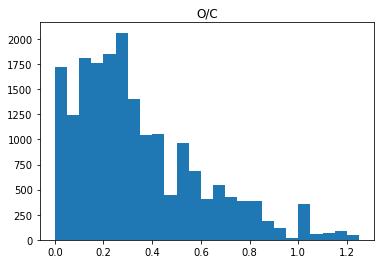

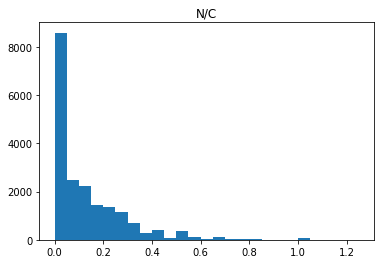

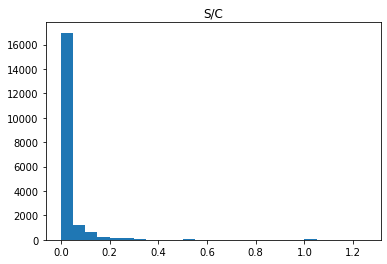

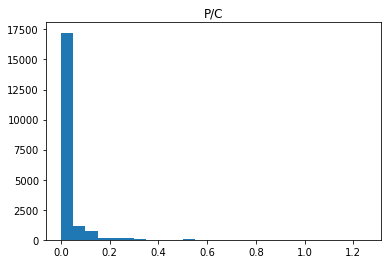

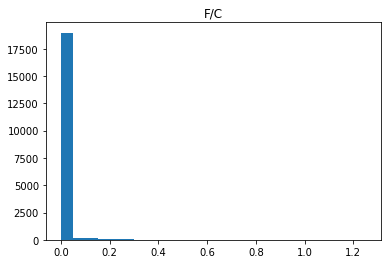

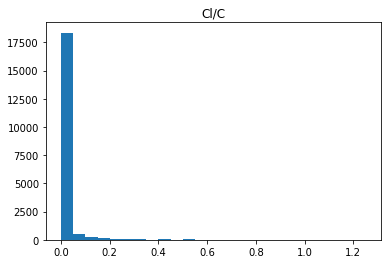

In [16]:
for i in ratios_df.columns[1:]:
    data = ratios_df[i]
    plt.hist(data, bins=np.arange(min(data), 1.3, 0.05))
    plt.title(i)
    plt.show()

#### (Percent) Cumulative Graphs of % of formulas by a certain element/Carbon ratio

First is presented the general cumulative graph, and then two different subsections of the graph to present in more detail: the 'end' of the curves (all except 'H/C') and the 'start' of the curves (especially 'H/C').

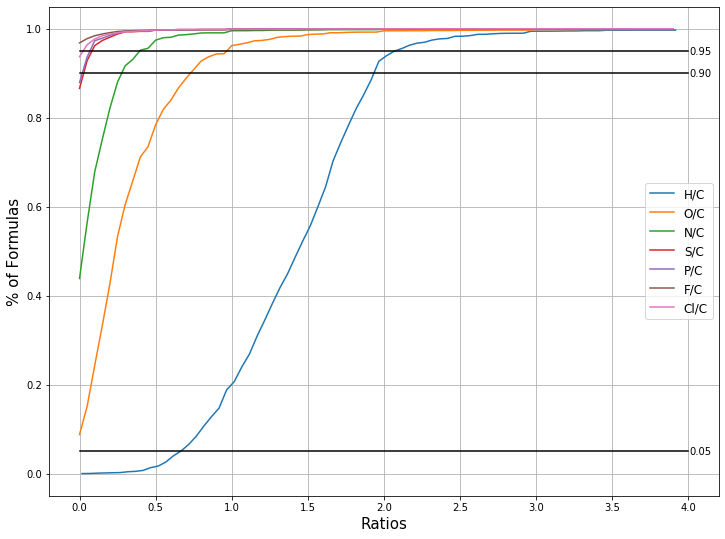

In [17]:
# Plot the cumulative graph and adjust parameters
f, ax = plt.subplots(figsize=(12,9))
for i in ratios_df.columns:
    data = ratios_df[i]
    # Make the histogram with the intended ranges between the bins
    values, base = np.histogram(data, bins=np.arange(min(data), 4, 0.05)) # Set X
    # Calculate the cumulative % of formulas for each ratio
    cumulative = np.cumsum(values)/len(ratios_df) # 
    #print(cumulative)
    plt.plot(base[:-1], cumulative)

plt.plot([0,4],[0.05,0.05], color = 'black');plt.text(x=4.01, y=0.05, s='0.05', verticalalignment='center')
plt.plot([0,4],[0.9,0.9], color = 'black');plt.text(x=4.01, y=0.90, s='0.90', verticalalignment='center')
plt.plot([0,4],[0.95,0.95], color = 'black');plt.text(x=4.01, y=0.95, s='0.95', verticalalignment='center')
plt.legend(ratios_df.columns, fontsize = 12)
plt.xlabel('Ratios', fontsize = 15)
plt.ylabel('% of Formulas', fontsize = 15)
plt.grid()

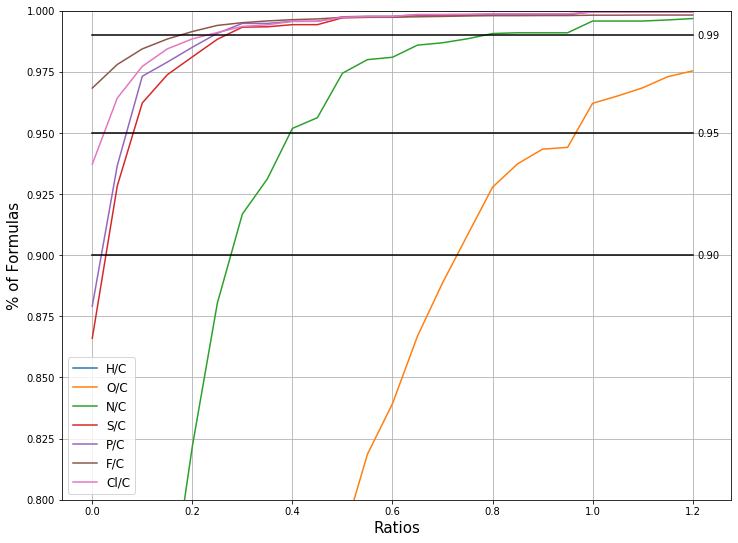

In [18]:
# Plot the cumulative graph and adjust parameters
f, ax = plt.subplots(figsize=(12,9))
for i in ratios_df.columns:
    data = ratios_df[i]
    # Plot the histogram
    values, base = np.histogram(data, bins=np.arange(min(data), 1.3, 0.05)) # Set X
    # Calculate the 
    cumulative = (np.cumsum(values)/len(ratios_df))
    #cumulative = np.cumsum(values)/len(ratios_df)
    plt.plot(base[:-1], cumulative)

plt.ylim([0.8,1])
plt.plot([0,1.2],[0.9,0.9], color = 'black');plt.text(x=1.21, y=0.90, s='0.90', verticalalignment='center')
plt.plot([0,1.2],[0.95,0.95], color = 'black');plt.text(x=1.21, y=0.95, s='0.95', verticalalignment='center')
plt.plot([0,1.2],[0.99,0.99], color = 'black');plt.text(x=1.21, y=0.99, s='0.99', verticalalignment='center')
plt.legend(ratios_df.columns, fontsize = 12)
plt.xlabel('Ratios', fontsize = 15)
plt.ylabel('% of Formulas', fontsize = 15)
plt.grid()

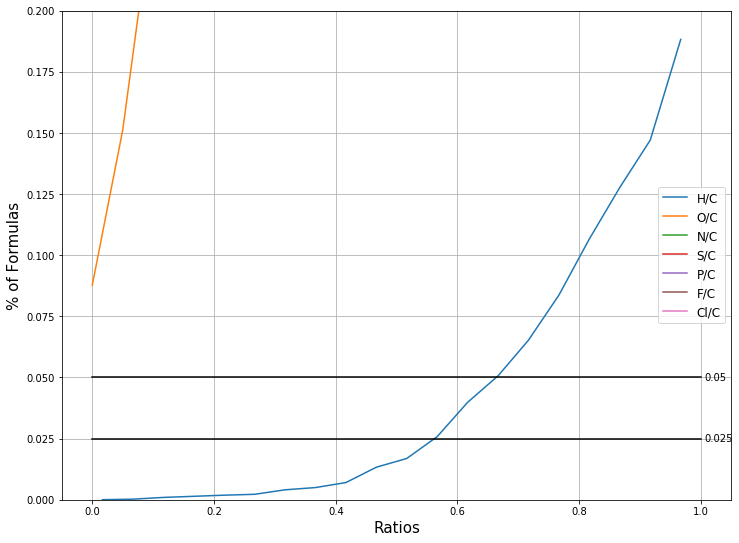

In [19]:
# Plot the cumulative graph and adjust parameters
f, ax = plt.subplots(figsize=(12,9))
for i in ratios_df.columns:
    data = ratios_df[i]
    values, base = np.histogram(data, bins=np.arange(min(data), 1.05, 0.05)) # Set X
    cumulative = np.cumsum(values)/len(ratios_df)
    plt.plot(base[:-1], cumulative)

plt.ylim([0,0.2])
#plt.plot([0,1],[0.9,0.9], color = 'black')
plt.plot([0,1],[0.05,0.05], color = 'black');plt.text(x=1.005, y=0.05, s='0.05', verticalalignment='center')
plt.plot([0,1],[0.025,0.025], color = 'black');plt.text(x=1.005, y=0.025, s='0.025', verticalalignment='center')
plt.legend(ratios_df.columns, fontsize = 12)
plt.xlabel('Ratios', fontsize = 15)
plt.ylabel('% of Formulas', fontsize = 15)
plt.grid()

### Cumulative Graphs of the ratios - Eliminating ratios with 0

Outside of the ['H/C'] ratios, the ratios were dominated by formulas that didn't have the element that is not carbon. Thus for each ratio 'element/C', the formulas that didn't have the corresponding elements were not taken into account for the graph.

#### (Percent) Cumulative Graphs of % of formulas by a certain element/Carbon ratio

First is presented the general cumulative graph, and then two different subsections of the graph to present in more detail: the 'end' of the curves (all except 'H/C') and the 'start' of the curves (especially 'H/C').

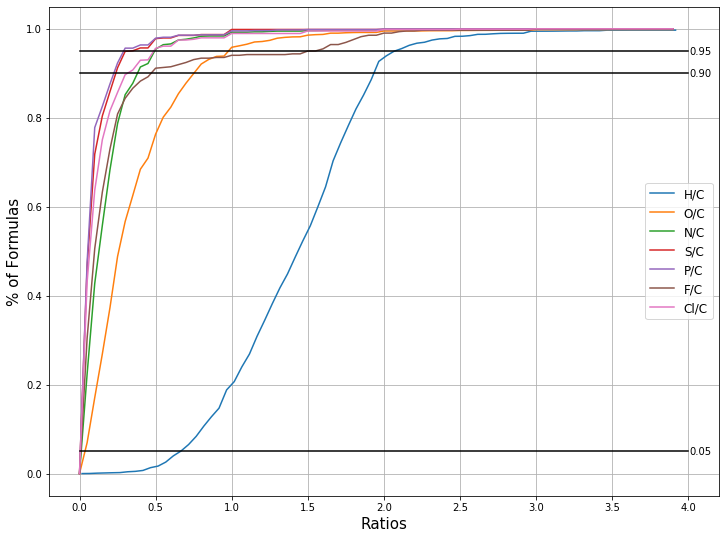

In [20]:
# Plot the Cumulative Graph and Adjust Parameters
f, ax = plt.subplots(figsize=(12,9))
for i in ratios_df.columns:
    data = ratios_df[i]
    values, base = np.histogram(data, bins=np.arange(min(data), 4, 0.05))
    
    # Subtract the number of formulas that don't have the otehr element that not carbon in the ratio (ratio=0, values[0]) from 
    # the number of formulas with ratio <= a value (np.cumsum(values)) and from the total number of formulas (len(ratios_df))
    cumulative = (np.cumsum(values) - values[0])/(len(ratios_df) - values[0])
    #print(cumulative)
    plt.plot(base[:-1], cumulative)

plt.plot([0,4],[0.05,0.05], color = 'black');plt.text(x=4.01, y=0.05, s='0.05', verticalalignment='center')
plt.plot([0,4],[0.9,0.9], color = 'black');plt.text(x=4.01, y=0.90, s='0.90', verticalalignment='center')
plt.plot([0,4],[0.95,0.95], color = 'black');plt.text(x=4.01, y=0.95, s='0.95', verticalalignment='center')
plt.legend(ratios_df.columns, fontsize = 12)
plt.xlabel('Ratios', fontsize = 15)
plt.ylabel('% of Formulas', fontsize = 15)
plt.grid()

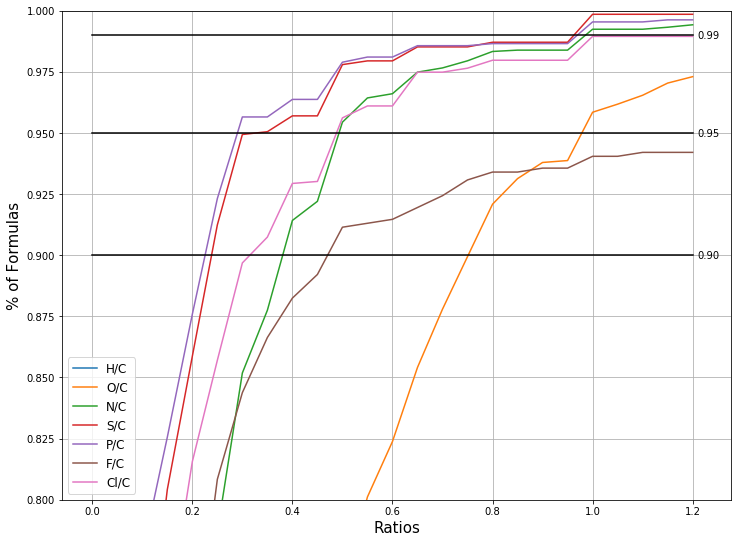

In [21]:
# Plot the Cumulative Graph and Adjust Parameters
f, ax = plt.subplots(figsize=(12,9))
for i in ratios_df.columns:
    data = ratios_df[i]
    values, base = np.histogram(data, bins=np.arange(min(data), 1.3, 0.05))
    cumulative = (np.cumsum(values) - values[0])/(len(ratios_df) - values[0])
    #cumulative = np.cumsum(values)/19608
    plt.plot(base[:-1], cumulative)

plt.ylim([0.8,1])
plt.plot([0,1.2],[0.9,0.9], color = 'black');plt.text(x=1.21, y=0.90, s='0.90', verticalalignment='center')
plt.plot([0,1.2],[0.95,0.95], color = 'black');plt.text(x=1.21, y=0.95, s='0.95', verticalalignment='center')
plt.plot([0,1.2],[0.99,0.99], color = 'black');plt.text(x=1.21, y=0.99, s='0.99', verticalalignment='center')
plt.legend(ratios_df.columns, fontsize = 12)
plt.xlabel('Ratios', fontsize = 15)
plt.ylabel('% of Formulas', fontsize = 15)
plt.grid()

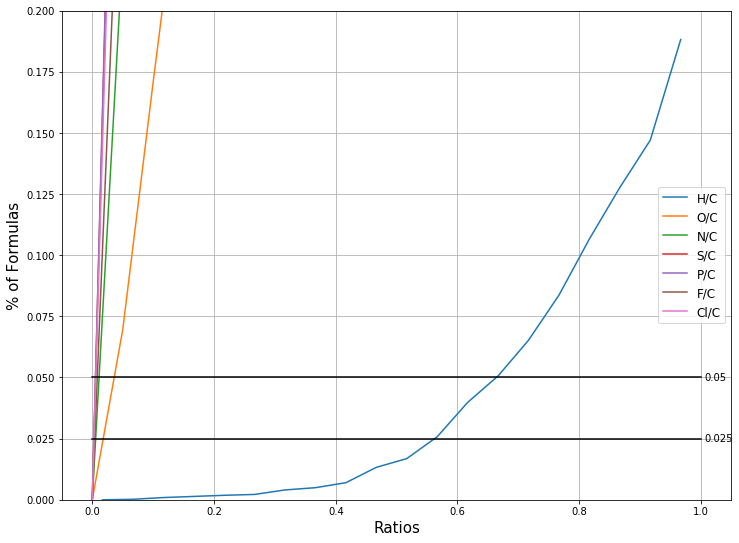

In [22]:
# Plot the Cumulative Graph and Adjust Parameters
f, ax = plt.subplots(figsize=(12,9))
for i in ratios_df.columns:
    data = ratios_df[i]
    values, base = np.histogram(data, bins=np.arange(min(data), 1.05, 0.05))
    cumulative = (np.cumsum(values) - values[0])/(len(ratios_df) - values[0])
    plt.plot(base[:-1], cumulative)

plt.ylim([0,0.2])
#plt.plot([0,1],[0.9,0.9], color = 'black')
plt.plot([0,1],[0.05,0.05], color = 'black');plt.text(x=1.005, y=0.05, s='0.05', verticalalignment='center')
plt.plot([0,1],[0.025,0.025], color = 'black');plt.text(x=1.005, y=0.025, s='0.025', verticalalignment='center')
plt.legend(ratios_df.columns, fontsize = 12)
plt.xlabel('Ratios', fontsize = 15)
plt.ylabel('% of Formulas', fontsize = 15)
plt.grid()

# ChEBI with all metabolites in the Database - Slower

This analysis is exactly the same as the made before from the 2nd cell down, only the cell that reads the file is different.

## Reading and Storing Formulas from a Database 

In [23]:
# Open Database file
with open('ChEBI_complete_3star.sdf/ChEBI_complete.sdf') as file: 
    formula = False
    form2=[]
    for line in file:
        # Append all formulas
        if formula == True:
            form2.append(line[:-1])
            #print(line[:-1])
        # Read next line
        if line.startswith('> <Formulae>'):
            formula = True
        else:
            formula = False
#form2   

In [24]:
# Nº of formulas in the Database
len(form2)

113402

### Filter the formulas in the database

Filter formulas with:
- an unspecified R group or X halogen, 
- formulas that could have a section repeated n times (polymers), 
- formulas with non-covalent bonds represented by a '.' such as '(C6H8O6)n.H2O',
- formulas with isotopes such as C6H11[18F]O5,
- formulas without carbons or hydrogens.

In [25]:
formulas2 = []
tot_form = len(form)

#c,r,n,p,x,n=0,0,0,0,0,0

for i in form2:
    if 'C' in i: # Has to have Carbon (this is actually: has to have carbon, Cl, Ca, Cu, Cr, Cs or Cd - fixed later)
        #c=c+1
        if 'R' not in i: # No unspecified R groups
            #r=r+1
            if 'n' not in i: # No polymers with sections that can be repeated n times
                #n=n+1
                if '.' not in i: # No formulas that could have non-covalent bonds
                    #p=p+1
                    if 'X' not in i: # No unspecified X halogens
                        #x=x+1
                        if '[' not in i: # No
                            if 'H' in i: # Has to have Hydrogen (this is actually: has to have hydrogen or mercury - fixed later)
                                #h = h+1
                                formulas2.append(i)
#print(c,r,n,p,x,h)
print('Nº of formulas after filtering:', len(formulas2))

print('Nº of non-repeating formulas after filtering:', len(set(formulas2)))

Nº of formulas after filtering: 106052
Nº of non-repeating formulas after filtering: 37938


There are 106052 formulas remaining after filtering, 37938 of those were unique different formulas (more than half of the formulas were repeated).

In [26]:
#len(set(formulas2))
#formulas2 = set(formulas2)
#formulas2[:20]

#### Transform formulas into Dictionary/DataFrame format (from string format) and take out repeating formulas (done automatically by this process)

In [27]:
# Transform each formula into Dictionary or DataFrame format
# This also elimiantes repeating formulas
db2 = {}
for i in formulas2:
    #print(i)
    db2[i] = formula_process(i)

In [28]:
# Transform information into a DataFrame
final_db2 = pd.DataFrame.from_dict(db2).T
final_db2

,C,H,O,Cl,N,P,S,F,Br,I,...,Ti,Zr,Li,Ir,U,Pd,T,Pr,Tl,Ba
C15H14O6,15.0,14.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C10H16O,10.0,16.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C18H22O3,18.0,22.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C7H3Cl2N,7.0,3.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C4H8O3,4.0,8.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C8H8NO6P,8.0,8.0,6.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C204H301N51O64,204.0,301.0,64.0,NaN,51.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C32H26N4O2,32.0,26.0,2.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C8H10N4O3,8.0,10.0,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


See the elements present in the list of formulas and also the number of times each element appear in a formulas

Note that C appear in 37874 and H in 37933 formulas out of the 37938 formulas, when they should appear in all formulas. This discrepancy is explaiend by the comment made in the formula filtering cell a bit above. It will be solved in a bit.

In [29]:
#final_db[final_db['Se'].notnull()].T
final_db2.notnull().sum()

C     37874
H     37933
O     35160
Cl     4610
N     29361
P      5021
S     10838
F      3598
Br     1206
I       287
K        52
Se       62
Mg       66
Co       68
As       67
Fe       99
Hg       39
Pt       20
Ni       22
W         6
Ca       34
B        70
Si       92
Cu       20
Na      373
V         3
D        17
Bi        7
Sb        4
Au        6
Te        9
Ag        2
Tc        1
Mo       29
Cr       11
Al        8
Pb        5
Os        2
Gd       11
Ge        1
Eu        3
Cs        1
Sr        1
Cd        4
Mu        1
Ti        3
Zr        2
Li       19
Ir        5
U         4
Pd        4
T         1
Pr        1
Tl        1
Ba        2
dtype: int64

#### Guarantee that each formula has at least 1 C and 1 H, and that only have the following elements: C,H,O,N,S,P,Cl and F

Only formulas with C,H,O,N,S,P,Cl and F were kept since they are (as we can also see above) by far the most common elements in metabolites and are the elements that can be considered (right now as it is built) in the Formula Assignment algorithm made in FormGeneration_Assignment.ipynb (this notebook is auxiliary to that one to observe the most common ratios between these elemetns in known metabolites).

In [30]:
# Only keep formulas that have carbon or hydrogen atoms
for i in range(2):
    teste = final_db2.iloc[:,i].notnull()
    #print(final_db2.iloc[:,i].isnull())
    final_db2 = final_db2.loc[teste]
    
# Take out formulas that have an element outside of the C,H,O,N,S,P,Cl and F
for i in range(8,len(final_db2.columns)):
    teste = final_db2.iloc[:,i].isnull()
    final_db2 = final_db2.loc[teste]
final_db2

,C,H,O,Cl,N,P,S,F,Br,I,...,Ti,Zr,Li,Ir,U,Pd,T,Pr,Tl,Ba
C15H14O6,15.0,14.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C10H16O,10.0,16.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C18H22O3,18.0,22.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C7H3Cl2N,7.0,3.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C4H8O3,4.0,8.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C8H8NO6P,8.0,8.0,6.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C204H301N51O64,204.0,301.0,64.0,NaN,51.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C32H26N4O2,32.0,26.0,2.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C8H10N4O3,8.0,10.0,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### This finally filters the number of formulas from 37938 to 35245 formulas - final number of formulas considered

As it can be seen by this small filtering, very few formulas had elements outside of the main 8 mentioned.

In [31]:
final_db2.notnull().sum()

C     35245
H     35245
O     32810
Cl     4337
N     27357
P      4880
S     10142
F      3446
Br        0
I         0
K         0
Se        0
Mg        0
Co        0
As        0
Fe        0
Hg        0
Pt        0
Ni        0
W         0
Ca        0
B         0
Si        0
Cu        0
Na        0
V         0
D         0
Bi        0
Sb        0
Au        0
Te        0
Ag        0
Tc        0
Mo        0
Cr        0
Al        0
Pb        0
Os        0
Gd        0
Ge        0
Eu        0
Cs        0
Sr        0
Cd        0
Mu        0
Ti        0
Zr        0
Li        0
Ir        0
U         0
Pd        0
T         0
Pr        0
Tl        0
Ba        0
dtype: int64

In [32]:
# Truncate the DataFrame to only the elements we want to see and replace NaNs for 0
db_df2 = final_db2[['C','H','O','N','S','P','F','Cl']]
db_df2 = db_df2.replace({np.nan:0})
db_df2

,C,H,O,N,S,P,F,Cl
C15H14O6,15.0,14.0,6.0,0.0,0.0,0.0,0.0,0.0
C10H16O,10.0,16.0,1.0,0.0,0.0,0.0,0.0,0.0
C18H22O3,18.0,22.0,3.0,0.0,0.0,0.0,0.0,0.0
C7H3Cl2N,7.0,3.0,0.0,1.0,0.0,0.0,0.0,2.0
C4H8O3,4.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
C8H8NO6P,8.0,8.0,6.0,1.0,0.0,1.0,0.0,0.0
C204H301N51O64,204.0,301.0,64.0,51.0,0.0,0.0,0.0,0.0
C32H26N4O2,32.0,26.0,2.0,4.0,0.0,0.0,0.0,0.0
C8H10N4O3,8.0,10.0,3.0,4.0,0.0,0.0,0.0,0.0


Calculate the distribution of ratios to carbon in the 19593 formulas - slowest cell of the notebook

In [33]:
# Calculate the different ratios 
ratios_df2 = pd.DataFrame(index=db_df2.index, columns = ['H/C','O/C','N/C','S/C','P/C','F/C','Cl/C'])
c = 0
for i in db_df2.index:
    ratios_df2.loc[i] = [db_df2.loc[i,'H']/db_df2.loc[i,'C'],
                         db_df2.loc[i,'O']/db_df2.loc[i,'C'],
                         db_df2.loc[i,'N']/db_df2.loc[i,'C'],
                         db_df2.loc[i,'S']/db_df2.loc[i,'C'],
                         db_df2.loc[i,'P']/db_df2.loc[i,'C'],
                         db_df2.loc[i,'F']/db_df2.loc[i,'C'],
                         db_df2.loc[i,'Cl']/db_df2.loc[i,'C']]
    c+=1
    #print(c)
ratios_df2

,H/C,O/C,N/C,S/C,P/C,F/C,Cl/C
C15H14O6,0.933333,0.4,0,0,0,0,0
C10H16O,1.6,0.1,0,0,0,0,0
C18H22O3,1.22222,0.166667,0,0,0,0,0
C7H3Cl2N,0.428571,0,0.142857,0,0,0,0.285714
C4H8O3,2,0.75,0,0,0,0,0
...,...,...,...,...,...,...,...
C8H8NO6P,1,0.75,0.125,0,0.125,0,0
C204H301N51O64,1.47549,0.313725,0.25,0,0,0,0
C32H26N4O2,0.8125,0.0625,0.125,0,0,0,0
C8H10N4O3,1.25,0.375,0.5,0,0,0,0


# Analysis of the ratios of 'Element'/Carbon

### Histograms and more importantly Cumulative Graphs of the ratios - Not eliminating ratios with 0

Outside of the ['H/C'] ratios, the ratios were dominated by formulas that didn't have the element that is not carbon which skewed the following results.

#### Histograms of the each of the ratios

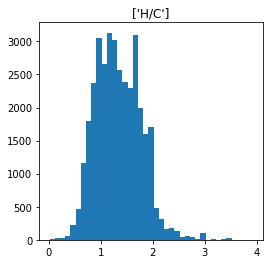

In [34]:
f, ax = plt.subplots(figsize=(4,4))
data = ratios_df2['H/C']
plt.hist(data, bins=np.arange(min(data), 4, 0.1))
plt.title(['H/C'])
plt.show()

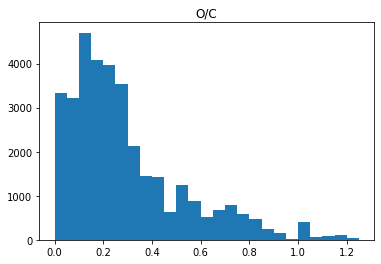

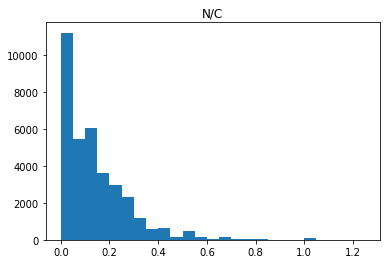

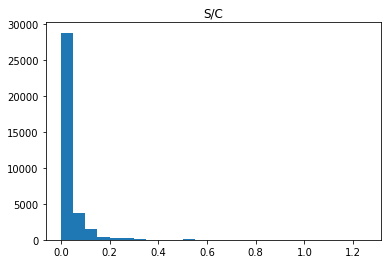

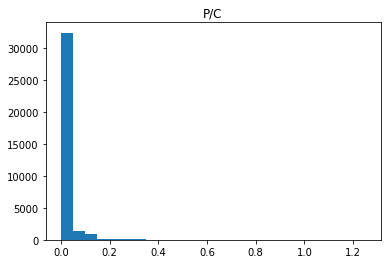

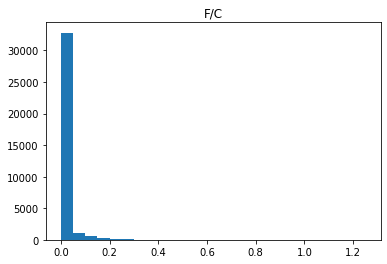

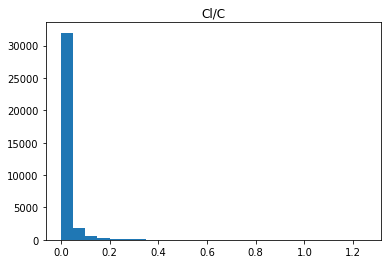

In [35]:
for i in ratios_df2.columns[1:]:
    data = ratios_df2[i]
    plt.hist(data, bins=np.arange(min(data), 1.3, 0.05))
    plt.title(i)
    plt.show()

#### (Percent) Cumulative Graphs of % of formulas by a certain element/Carbon ratio

First is presented the general cumulative graph, and then two different subsections of the graph to present in more detail: the 'end' of the curves (all except 'H/C') and the 'start' of the curves (especially 'H/C').

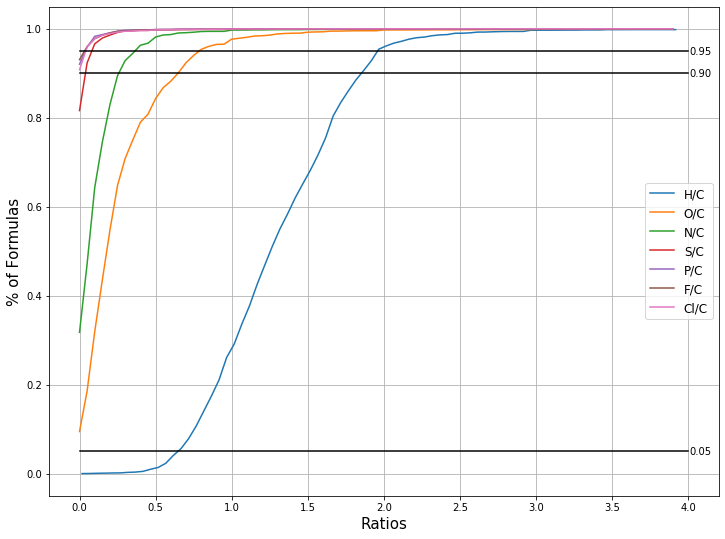

In [36]:
# Plot the cumulative graph and adjust parameters
f, ax = plt.subplots(figsize=(12,9))
for i in ratios_df2.columns:
    data = ratios_df2[i]
    # Make the histogram with the intended ranges between the bins
    values, base = np.histogram(data, bins=np.arange(min(data), 4, 0.05)) # Set X
    # Calculate the cumulative % of formulas for each ratio
    cumulative = np.cumsum(values)/len(ratios_df2) # 
    #print(cumulative)
    plt.plot(base[:-1], cumulative)

plt.plot([0,4],[0.05,0.05], color = 'black');plt.text(x=4.01, y=0.05, s='0.05', verticalalignment='center')
plt.plot([0,4],[0.9,0.9], color = 'black');plt.text(x=4.01, y=0.90, s='0.90', verticalalignment='center')
plt.plot([0,4],[0.95,0.95], color = 'black');plt.text(x=4.01, y=0.95, s='0.95', verticalalignment='center')
plt.legend(ratios_df.columns, fontsize = 12)
plt.xlabel('Ratios', fontsize = 15)
plt.ylabel('% of Formulas', fontsize = 15)
plt.grid()

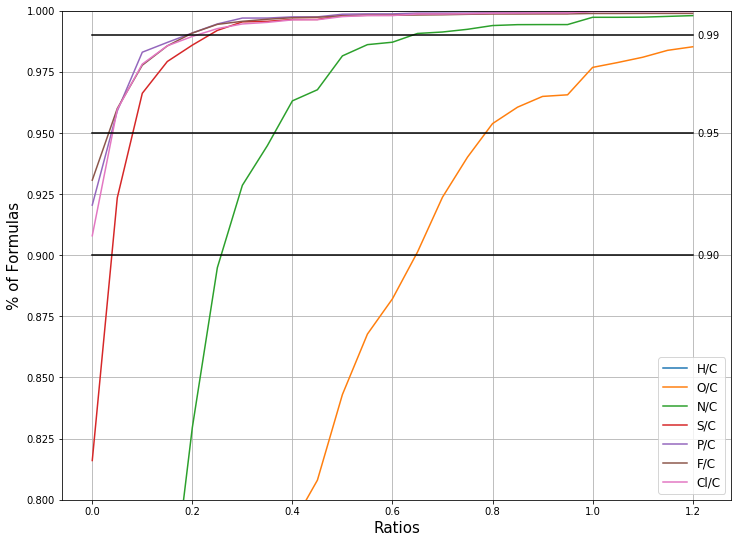

In [37]:
# Plot the cumulative graph and adjust parameters
f, ax = plt.subplots(figsize=(12,9))
for i in ratios_df2.columns:
    data = ratios_df2[i]
    # Plot the histogram
    values, base = np.histogram(data, bins=np.arange(min(data), 1.3, 0.05)) # Set X
    # Calculate the 
    cumulative = (np.cumsum(values)/len(ratios_df2))
    #cumulative = np.cumsum(values)/len(ratios_df2)
    plt.plot(base[:-1], cumulative)

plt.ylim([0.8,1])
plt.plot([0,1.2],[0.9,0.9], color = 'black');plt.text(x=1.21, y=0.90, s='0.90', verticalalignment='center')
plt.plot([0,1.2],[0.95,0.95], color = 'black');plt.text(x=1.21, y=0.95, s='0.95', verticalalignment='center')
plt.plot([0,1.2],[0.99,0.99], color = 'black');plt.text(x=1.21, y=0.99, s='0.99', verticalalignment='center')
plt.legend(ratios_df.columns, fontsize = 12)
plt.xlabel('Ratios', fontsize = 15)
plt.ylabel('% of Formulas', fontsize = 15)
plt.grid()

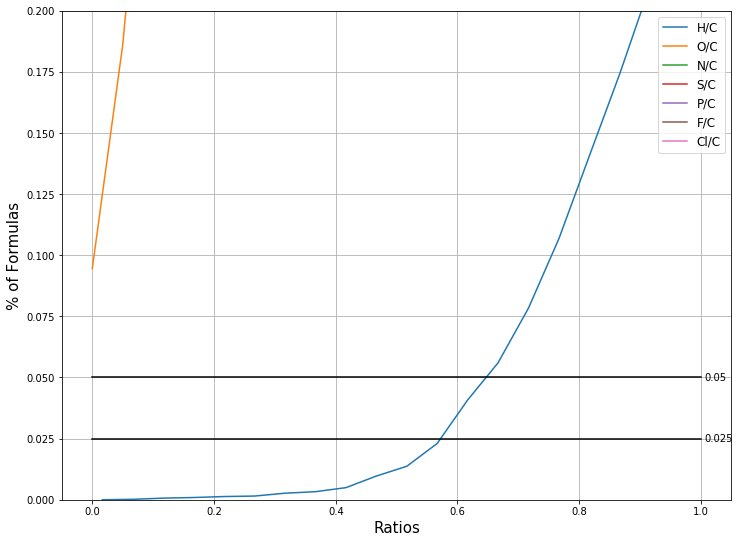

In [38]:
# Plot the cumulative graph and adjust parameters
f, ax = plt.subplots(figsize=(12,9))
for i in ratios_df2.columns:
    data = ratios_df2[i]
    values, base = np.histogram(data, bins=np.arange(min(data), 1.05, 0.05)) # Set X
    cumulative = np.cumsum(values)/len(ratios_df2)
    plt.plot(base[:-1], cumulative)

plt.ylim([0,0.2])
#plt.plot([0,1],[0.9,0.9], color = 'black')
plt.plot([0,1],[0.05,0.05], color = 'black');plt.text(x=1.005, y=0.05, s='0.05', verticalalignment='center')
plt.plot([0,1],[0.025,0.025], color = 'black');plt.text(x=1.005, y=0.025, s='0.025', verticalalignment='center')
plt.legend(ratios_df.columns, fontsize = 12)
plt.xlabel('Ratios', fontsize = 15)
plt.ylabel('% of Formulas', fontsize = 15)
plt.grid()

### Cumulative Graphs of the ratios - Eliminating ratios with 0

Outside of the ['H/C'] ratios, the ratios were dominated by formulas that didn't have the element that is not carbon. Thus for each ratio 'element/C', the formulas that didn't have the corresponding elements were not taken into account for the graph.

#### (Percent) Cumulative Graphs of % of formulas by a certain element/Carbon ratio

First is presented the general cumulative graph, and then two different subsections of the graph to present in more detail: the 'end' of the curves (all except 'H/C') and the 'start' of the curves (especially 'H/C').

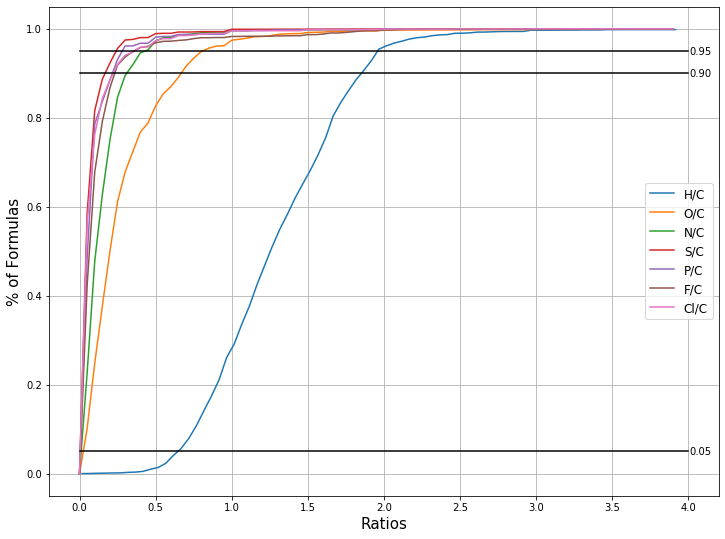

In [39]:
# Plot the Cumulative Graph and Adjust Parameters
f, ax = plt.subplots(figsize=(12,9))
for i in ratios_df2.columns:
    data = ratios_df2[i]
    values, base = np.histogram(data, bins=np.arange(min(data), 4, 0.05))
    
    # Subtract the number of formulas that don't have the otehr element that not carbon in the ratio (ratio=0, values[0]) from 
    # the number of formulas with ratio <= a value (np.cumsum(values)) and from the total number of formulas (len(ratios_df))
    cumulative = (np.cumsum(values) - values[0])/(len(ratios_df2) - values[0])
    #print(cumulative)
    plt.plot(base[:-1], cumulative)

plt.plot([0,4],[0.05,0.05], color = 'black');plt.text(x=4.01, y=0.05, s='0.05', verticalalignment='center')
plt.plot([0,4],[0.9,0.9], color = 'black');plt.text(x=4.01, y=0.90, s='0.90', verticalalignment='center')
plt.plot([0,4],[0.95,0.95], color = 'black');plt.text(x=4.01, y=0.95, s='0.95', verticalalignment='center')
plt.legend(ratios_df.columns, fontsize = 12)
plt.xlabel('Ratios', fontsize = 15)
plt.ylabel('% of Formulas', fontsize = 15)
plt.grid()

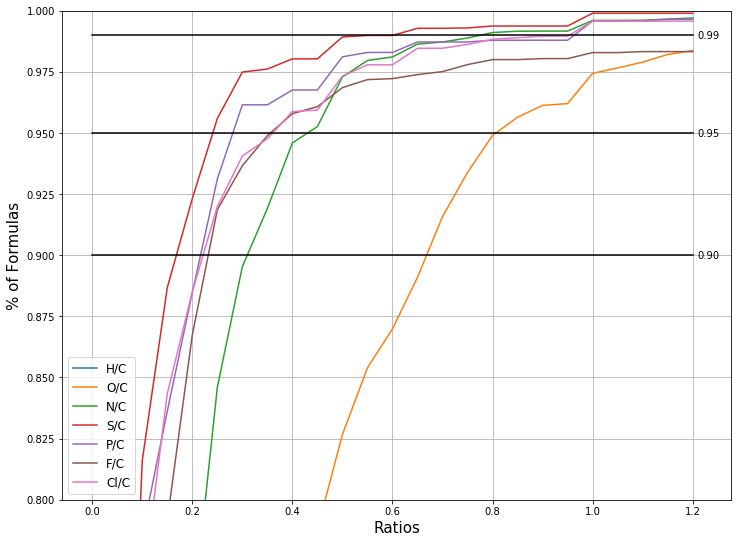

In [40]:
# Plot the Cumulative Graph and Adjust Parameters
f, ax = plt.subplots(figsize=(12,9))
for i in ratios_df2.columns:
    data = ratios_df2[i]
    values, base = np.histogram(data, bins=np.arange(min(data), 1.3, 0.05))
    cumulative = (np.cumsum(values) - values[0])/(len(ratios_df2) - values[0])
    plt.plot(base[:-1], cumulative)

plt.ylim([0.8,1])
plt.plot([0,1.2],[0.9,0.9], color = 'black');plt.text(x=1.21, y=0.90, s='0.90', verticalalignment='center')
plt.plot([0,1.2],[0.95,0.95], color = 'black');plt.text(x=1.21, y=0.95, s='0.95', verticalalignment='center')
plt.plot([0,1.2],[0.99,0.99], color = 'black');plt.text(x=1.21, y=0.99, s='0.99', verticalalignment='center')
plt.legend(ratios_df.columns, fontsize = 12)
plt.xlabel('Ratios', fontsize = 15)
plt.ylabel('% of Formulas', fontsize = 15)
plt.grid()

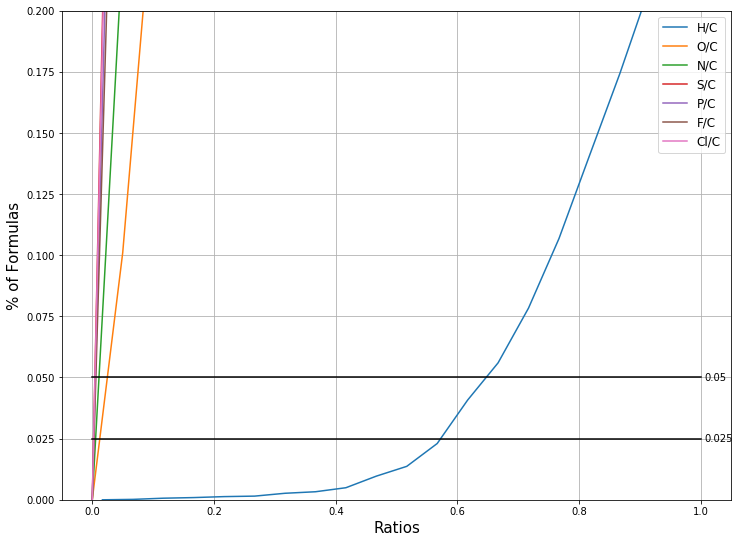

In [41]:
# Plot the Cumulative Graph and Adjust Parameters
f, ax = plt.subplots(figsize=(12,9))
for i in ratios_df2.columns:
    data = ratios_df2[i]
    values, base = np.histogram(data, bins=np.arange(min(data), 1.05, 0.05))
    cumulative = (np.cumsum(values) - values[0])/(len(ratios_df2) - values[0])
    plt.plot(base[:-1], cumulative)

plt.ylim([0,0.2])
#plt.plot([0,1],[0.9,0.9], color = 'black')
plt.plot([0,1],[0.05,0.05], color = 'black');plt.text(x=1.005, y=0.05, s='0.05', verticalalignment='center')
plt.plot([0,1],[0.025,0.025], color = 'black');plt.text(x=1.005, y=0.025, s='0.025', verticalalignment='center')
plt.legend(ratios_df.columns, fontsize = 12)
plt.xlabel('Ratios', fontsize = 15)
plt.ylabel('% of Formulas', fontsize = 15)
plt.grid()

## Conclusions about the ranges to use

## Ranges conclusion

The ranges presented below (short_range) were applied at the form_checker_ratios function presented at the end of FormGeneration_Assignment.ipynb as an extra criteria for Formula Assignment to impede attribution of formulas with really rare ratios over formulas with more common ratios.

These ranges chosen should still allow for 95 to 99% of all formulas according to the results obtained with the ChEBI databases. Maybe even more strict ranges should be taken (from 90% or even lower) to make more strict selections.

Stricter_ranges is a possible stricter ranges to use

In [42]:
short_range = {'H/C':(0.5,2.2),'N/C':(0,0.6),'O/C':(0,1.2),'P/C':(0,0.3),'S/C':(0,0.5),'F/C':(0,0.5), 'Cl/C':(0,0.5)}

In [43]:
stricter_ranges = {'H/C':(0.6,2.2),'N/C':(0,0.5),'O/C':(0,1),'P/C':(0,0.3),'S/C':(0,0.3),'F/C':(0,0.5), 'Cl/C':(0,0.5)}